In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
run -im djd.main -- --dbname=dj_lisa -r

For remote access to work, make sure to first open an SSH tunnel with MySQL
port forwarding. Run the `djdtunnel` script in a separate terminal, with
optional `--user` argument if your local and remote user names differ.
Or, open the tunnel manually with:
  ssh -NL 3306:huxley.neuro.bzm:3306 -p 1021 USERNAME@tunnel.bio.lmu.de
Connecting execute@localhost:3306
Connected to database 'dj_lisa' as 'execute@10.153.172.3'
For remote file access to work, make sure to first mount the filesystem at tunnel.bio.lmu.de:1021 via SSHFS with `hux -r`


In [4]:
from djd import glms
from djd import plot
from hmov_code import hmov_utils

In [5]:
def plot_model(key, spl_model, data, paramdict, burn_in, cmap='RdBu',
    smooth='spline16', test_idx=0,
    train_trange=[0, 180], linew_psth=0.7, title=True, figsize=(12, 5),
               savefig=True, add_info=None, dpi=150):
    """ Plot spatial-temporal receptive field and predictions.
    
    Parameters
    ----------
    key: dict
        mseu info
    spl_model: obj
        RFEst model object
    data: obj
        Data object with stimulus and responses
    paramdict: dict
        Parameter dictionary
    cmap: str
        Color map. Default: 'RdBu'
    smooth: str
        Smoothing parameter for imshow (spatial RF). Default: 'spline16'
    test_idx: int
        Index which test sequence should be plotted
    train_trange: list
        Time range for which PSTH and prediction should be shown
        E.g. [0, 180]
    linew_psth: float
        Linewidth of the observed PSTH.
    title: bool
        If true, unit info will be shown in title.
    figsize: np.array
        Figure size
    savefig: bool
        If True the figure is saved automatically at './plots/'.
    dpi: int
        Resolution of the saved figure. Only relevant if savefig is True.
    """
    from sklearn.decomposition import randomized_svd
    from sklearn.metrics import explained_variance_score
    from djd import plot
    from hmov_code import hmov_utils
    
    color_dict = plot.get_color_dict(color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])
    color_dict_dark = plot.get_color_dict(palette_name='dark', color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])

    assert {'m', 's', 'e', 'u'} <= key.keys(), ("Restriction must specify a single unit.")
    params = {'spl_stim', 'spl_lambda', 'spl_lr', 'spl_max_iter', 'spl_spat_df', 'spl_temp_df',
              'spl_nlag', 'spl_pshf', 'spl_pshf_len', 'spl_pshf_df', 'spl_opto',
              'spl_opto_len',
              'spl_opto_df', 'spl_run', 'spl_run_len', 'spl_run_df', 'spl_eye', 'spl_eye_len',
              'spl_eye_df'}
    assert params <= paramdict.keys(), ("paramdict misses necessary parameter.")

    # Get model and param info
    dims = [paramdict['spl_nlag'], data.stimulus['train'].shape[1], data.stimulus['train'].shape[2]]

    # Normalize weights
    w_vec = spl_model.w_opt['stimulus']
    k_norm = w_vec / np.linalg.norm(w_vec)
    w_norm = k_norm.reshape(dims)

    # SVD
    dims_tRF = dims[0]
    dims_sRF = dims[1:]
    U, S, Vt = randomized_svd(k_norm.reshape(dims_tRF, np.prod(dims_sRF)), 3)
    sRF = Vt[0].reshape(*dims_sRF)
    tRF = U[:, 0]

    # Get predictions
    # Train
    yhat_train = spl_model.predict(X=train_dict)
    # Validation
    yhat_validation = spl_model.predict(X=validation_dict)
    # Test
    yhat_test_repeats = []
    for i in range(len(data.responses['test_repeats'])):
        test_dict = test_dicts[i]
        yhat_test_rep = spl_model.predict(X=test_dict)
        yhat_test_repeats.append(np.array(yhat_test_rep))

    # Get model prediction for test sequences as mean of predictions for each repeat
    # NOTE: This is not equivalent to computing the test prediction over the average
    # unit response over the test repeats, which will be less noisy and result in
    # overestimating test prediction quality
    yhat_test_mean = np.mean(np.vstack(yhat_test_repeats), axis=0)

    predicted_train = yhat_train
    observed_train = data.responses['train'][burn_in:]

    predicted_test_repeats = yhat_test_repeats
    observed_test_repeats = []
    for i in range(len(data.responses['test_repeats'])):
        observed_test_repeats.append(data.responses['test_repeats'][i][burn_in:])

    # Get model performance
    r_train = np.corrcoef(observed_train, predicted_train)[0, 1]
    r2_train = explained_variance_score(observed_train, predicted_train)

    # loop through test set
    nreps = len(observed_test_repeats)
    r_test_repeats = []
    r2_test_repeats = []
    for rep in range(nreps):
        if np.sum(observed_test_repeats[rep]) == 0:
            r_test_repeats.append(np.nan)
            r2_test_repeats.append(np.nan)
        else:
            r_test_repeats.append(np.corrcoef(observed_test_repeats[rep],
                                                 predicted_test_repeats[rep])[0, 1])
            r2_test_repeats.append(explained_variance_score(observed_test_repeats[rep],
                                                          predicted_test_repeats[rep]))
    r_test_mean = np.nanmean(r_test_repeats)
    r2_test_mean = np.nanmean(r2_test_repeats)

    # Plotting
    fig = plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((4, 10), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((4, 10), (0, 3), colspan=3)
    ax3 = plt.subplot2grid((4, 10), (0, 6))
    ax4 = plt.subplot2grid((4, 10), (0, 7))
    ax5 = plt.subplot2grid((4, 10), (0, 8))
    ax6 = plt.subplot2grid((4, 10), (0, 9))

    ax7 = plt.subplot2grid((4, 10), (1, 0))
    ax8 = plt.subplot2grid((4, 10), (1, 1))
    ax9 = plt.subplot2grid((4, 10), (1, 2))
    ax10 = plt.subplot2grid((4, 10), (1, 3))
    ax11 = plt.subplot2grid((4, 10), (1, 4))
    ax12 = plt.subplot2grid((4, 10), (1, 5))
    ax13 = plt.subplot2grid((4, 10), (1, 6))
    ax14 = plt.subplot2grid((4, 10), (1, 7))
    ax15 = plt.subplot2grid((4, 10), (1, 8))
    ax16 = plt.subplot2grid((4, 10), (1, 9))

    ax17 = plt.subplot2grid((4, 10), (2, 0), colspan=6, rowspan=2)
    ax18 = plt.subplot2grid((4, 10), (2, 6), colspan=4, rowspan=2, sharey=ax17)

    axs = [ax1, ax2, ax3, ax4, ax5, ax6, 
           ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, 
           ax17, ax18]

    # colors
    cmap = 'RdBu'
    vmax_sRF = max(abs(sRF.min()), abs(sRF.max()))
    vmax_strf = max(abs(k_norm.min()), abs(k_norm.max()))

    # x-axes
    ts = 1/paramdict['spl_data_fs']
    # x-tRF
    x_axis_tmp = np.round((np.arange(-ts*paramdict['spl_nlag']-paramdict['spl_shift']*ts, 0-paramdict['spl_shift']*ts, ts))*1000)
    # x pshf
    PSTH_BINW = 0.1
    shift_factor_h = int(PSTH_BINW / (1/paramdict['spl_data_fs']))
    shift_h = paramdict['spl_shift']*shift_factor_h
    x_axis_pshf = np.round((np.linspace(-ts*paramdict['spl_pshf_len']-shift_h*(ts), 0-shift_h*(ts), paramdict['spl_pshf_len']))*1000)
    x_axis_opto = np.round((np.arange(-ts*paramdict['spl_opto_len']-paramdict['spl_shift']*ts, 0-paramdict['spl_shift']*ts, ts))*1000)
    x_axis_run = np.round((np.arange(-ts*paramdict['spl_run_len']-paramdict['spl_shift']*ts, 0-paramdict['spl_shift']*ts, ts))*1000)
    x_axis_eye = np.round((np.arange(-ts*paramdict['spl_eye_len']-paramdict['spl_shift']*ts, 0-paramdict['spl_shift']*ts, ts))*1000)


    # x-train
    train_n = observed_train.shape[0]
    x_train = np.linspace(0,train_n*ts, train_n)
    #x-test
    test_n = observed_test_repeats[0].shape[0]
    x_test = np.linspace(0,test_n*ts, test_n)
    # Find common axis for additional filters
    add_filt = []
    if paramdict['spl_pshf'] == 'True':
        add_filt.append(spl_model.w_opt['history'])
    if paramdict['spl_opto'] == 'True':
        add_filt.append(spl_model.w_opt['opto'])
    if paramdict['spl_run'] == 'True':
        add_filt.append(spl_model.w_opt['run'])
    if paramdict['spl_eye'] == 'True':
        add_filt.append(spl_model.w_opt['eye'])
    if len(add_filt)!=0:
        yticks_add_filt = np.linspace(np.floor(np.min(np.vstack(add_filt))),
                                      np.ceil(np.max(np.vstack(add_filt))),
                                      3)
    # spat. RF
    im1 = ax1.imshow(sRF, cmap=cmap, interpolation='spline16', vmin=-vmax_sRF, vmax=vmax_sRF)
    cbar1 = fig.colorbar(im1, ax=ax1, aspect=10)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Spatial filter', y=1.1)

    #tRF
    ax2.plot(x_axis_tmp, tRF, '.-', color='k')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xlabel('Time (ms)')
    ax2.set_title('Temporal filter')
    ax2pos = ax2.get_position()
    ax2.set_position([ax2pos.x0, ax2pos.y0,  ax2pos.width-0.03, ax2pos.height])

    # post-spike
    if 'history' in spl_model.w_opt.keys():
        ax3.plot(x_axis_pshf, spl_model.w_opt['history'], '-', color='k')
        ax3.hlines(y=0, xmin=x_axis_pshf[0], xmax=x_axis_pshf[-1], color='gray', linestyle=':')
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.set_ylim(yticks_add_filt[0], yticks_add_filt[-1])
        ax3.set_yticks(yticks_add_filt)
        ax3.set_xticks([x_axis_pshf[int(len(x_axis_pshf)/3)], x_axis_pshf[-1]])
        ax3.set_title('pshf')
    else:
        ax3.clear()
        ax3.axis("off")
        ax3.set_visible(False)
        ax3.remove()

    # opto
    if 'opto' in spl_model.w_opt.keys():
        ax4.plot(x_axis_opto, spl_model.w_opt['opto'], '-', color=color_dict['blue'])
        ax4.hlines(y=0, xmin=x_axis_opto[0], xmax=x_axis_opto[-1], color='gray', linestyle=':')
        ax4.spines['right'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        ax4.set_ylim(yticks_add_filt[0], yticks_add_filt[-1])
        ax4.set_yticks([])
        ax4.set_xticks([x_axis_opto[int(len(x_axis_opto)/3)], x_axis_opto[-1]])
        ax4.set_title('opto')
    else:
        ax4.clear()
        ax4.axis("off")
        ax4.set_visible(False)
        ax4.remove()

    # run
    if 'run' in spl_model.w_opt.keys():
        ax5.plot(x_axis_run, spl_model.w_opt['run'], '-', color=color_dict['green'])
        ax5.hlines(y=0, xmin=x_axis_run[0], xmax=x_axis_run[-1], color='gray', linestyle=':')
        ax5.spines['right'].set_visible(False)
        ax5.spines['top'].set_visible(False)
        ax5.set_ylim(yticks_add_filt[0], yticks_add_filt[-1])
        ax5.set_yticks([])
        ax5.set_xticks([x_axis_run[int(len(x_axis_run)/3)], x_axis_run[-1]])
        ax5.set_title('run')
    else:
        ax5.clear()
        ax5.axis("off")
        ax5.set_visible(False)
        ax5.remove()

    # eye
    if 'eye' in spl_model.w_opt.keys():
        ax6.plot(x_axis_eye, spl_model.w_opt['eye'], '-', color=color_dict['orange'])
        ax6.hlines(y=0, xmin=x_axis_eye[0], xmax=x_axis_eye[-1], color='gray', linestyle=':')
        ax6.spines['right'].set_visible(False)
        ax6.spines['top'].set_visible(False)
        ax6.set_ylim(yticks_add_filt[0], yticks_add_filt[-1])
        ax6.set_yticks([])
        ax6.set_xticks([x_axis_eye[int(len(x_axis_eye)/3)], x_axis_eye[-1]])
        ax6.set_title('eye')
    else:
        ax6.clear()
        ax6.axis("off")
        ax6.set_visible(False)
        ax6.remove()

    # STRF
    axs_strf = [ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16]
    np.random.seed(seed=42)
    strf_is = np.sort(np.random.choice(np.arange(0,paramdict['spl_nlag'],1), size=10, replace=False))
    for i, strf_i in enumerate(strf_is):
        im = axs_strf[i].imshow(w_norm[strf_i, ...], cmap=cmap, vmin=-vmax_strf, vmax=vmax_strf, interpolation=smooth)
        axs_strf[i].set_xticks([])
        axs_strf[i].set_yticks([])
        axs_strf[i].set_title(str(int(x_axis_tmp[strf_i]))+' ms', fontsize=10)

        axpos = axs_strf[i].get_position()
        axs_strf[i].set_position([axpos.x0, axpos.y0 - 0.1,  axpos.width, axpos.height])
    fig.text(x=.73, y=.63, s='Time (ms)')

    # Training prediction
    ax17.plot(x_train, observed_train, label='train observed', c='k', linewidth=linew_psth)
    ax17.plot(x_train, yhat_train, label='train predicted', c=color_dict_dark['pink'], linewidth=2)
    ax17.set_xlim([train_trange[0],train_trange[1]])
    ax17.spines['right'].set_visible(False)
    ax17.spines['top'].set_visible(False)
    ax17.spines['left'].set_visible(False)
    ax17.set_yticks([])
    ax17.set_xlabel('Time (s)')
    ax17.legend(loc='upper left')
    ax17pos = ax17.get_position()
    ax17.set_position([ax17pos.x0, ax17pos.y0,  ax17pos.width, ax17pos.height-0.05])
    fig.text(x=0.5, y=0.35, s='$r$={:.2f}'.format(r_train))

    # Test prediction
    ax18.plot(x_test, observed_test_repeats[test_idx], label='test observed', c='k', linewidth=linew_psth)
    ax18.plot(x_test, yhat_test_repeats[test_idx], label='test predicted', c=color_dict_dark['pink'], linewidth=2)
    ax18.spines['right'].set_visible(False)
    ax18.spines['top'].set_visible(False)
    ax18.spines['left'].set_visible(False)
    ax18.set_yticks([])
    ax18.set_xlim(0,40)
    ax18.set_xlabel('Time (s)')
    ax18.legend(loc='upper left')
    ax18pos = ax18.get_position()
    ax18.set_position([ax18pos.x0, ax18pos.y0,  ax18pos.width, ax18pos.height-0.05])
    fig.text(x=0.83, y=0.35, s='$r$={:.2f}'.format(r_test_mean))

    if title is True:
        fig.suptitle('{:s} s{:02d} e{:02d} u{:02d}'.format(parentkey['m'],
                                                           parentkey['s'],
                                                           parentkey['e'],
                                                           parentkey['u'],
                                                          ), y=1.03)
    fig.patch.set_facecolor('white')


    if savefig is True:
        filename = hmov_utils.get_file_name(parentkey, paramdict, add_info=add_info)
        filepath = './plots/'
        fig.savefig('{:s}{:s}'.format(filepath, filename), dpi=dpi, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
        print('Figure saved at {:s}{:s}'.format(filepath, filename))

    return fig, axs

# Good example unit

In [6]:
key = {'m': 'Ntsr1Cre_2019_0008', 's': 5, 'e': 8, 'u': 19}
parentkey = key.copy()
parentkey['spl_paramset'] = 100

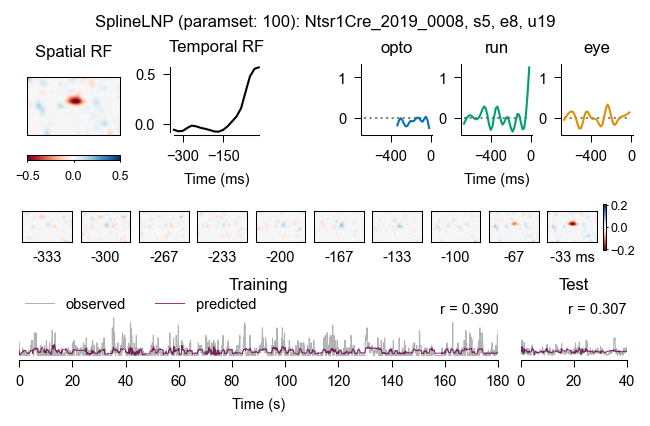

In [6]:
#fig, axs = glms.plot_model(parentkey)

# Get paramset

In [7]:
SplineLNPParams() & parentkey

spl_paramset parameter set ID,spl_stim stimulus name ('hmov' or 'spnoise'),spl_distr nonlinearity in LNP,spl_alpha weighting betw. L2 and L1 penalty (alpha=1 only uses L1),spl_lambda regularization parameter of penalty term,spl_lr initial learning rate for the JAX optimizer,spl_max_iter maximum number of iterations for the solver,spl_spat_df degrees of freedom num of basis functions for spatial domain,spl_temp_df degrees of freedom num of basis functions for temp component,spl_pshf fit post-spike history filter,spl_pshf_len length of the post-spike history filter,spl_pshf_df number of basis functions for post-spike history filter,spl_verb when verbose=n progress will be printed in every n steps,"spl_metric 'None', 'mse', 'r2', or 'corrcoef'",spl_norm_y normalize observed responses,spl_nlag number of time steps of the kernel,spl_shift shift kernel to not predict itself,spl_spat_scaling scaling factor for spatial resolution of movie,spl_data_fs temporal sampling frequency of the data,spl_opto fit optogenetics filter,spl_opto_len length of the opto filter (number of time steps),spl_opto_df number of basis functions for opto filter,spl_run fit running filter,spl_run_len length of the running filter (number of time steps),spl_run_df number of basis functions for running filter,spl_eye fit eye filter,spl_eye_len length of the eye filter (number of time steps),spl_eye_df number of basis functions for eye filter,spl_eye_smooth smooth eye data
100,hmov,softplus,1.0,1.0,0.3,1500,13,11,False,0,0,200,corrcoef,False,20,1,0.0495,60.0,True,20,11,True,40,13,True,40,13,True


In [8]:
paramdict = (SplineLNPParams() & parentkey).fetch(as_dict=True)[0]
paramdict

{'spl_paramset': 100,
 'spl_stim': 'hmov',
 'spl_distr': 'softplus',
 'spl_alpha': 1.0,
 'spl_lambda': 1.0,
 'spl_lr': 0.3,
 'spl_max_iter': 1500,
 'spl_spat_df': 13,
 'spl_temp_df': 11,
 'spl_pshf': 'False',
 'spl_pshf_len': 0,
 'spl_pshf_df': 0,
 'spl_verb': 200,
 'spl_metric': 'corrcoef',
 'spl_norm_y': 'False',
 'spl_nlag': 20,
 'spl_shift': 1,
 'spl_spat_scaling': 0.0495,
 'spl_data_fs': 60.0,
 'spl_opto': 'True',
 'spl_opto_len': 20,
 'spl_opto_df': 11,
 'spl_run': 'True',
 'spl_run_len': 40,
 'spl_run_df': 13,
 'spl_eye': 'True',
 'spl_eye_len': 40,
 'spl_eye_df': 13,
 'spl_eye_smooth': 'True'}

Now it is very easy to also change some parameters in `paramdict` to quick check for single units how this would influence the model fits. I usually do a few test runs before I decide for parameter ranges in the grid search.

If you change parameter values make sure to also change the `spl_paramset` to avoid confusion with populated fits.

In [9]:
# Imports
import re
from distutils.util import strtobool

verbose=True

In [10]:
# Get modelling parameters
# Either fetch them or hand over the paramdict
#pars = (SplineLNPParams() & parentkey).fetch1()
pars = paramdict.copy()
pars = {re.sub('spl_', '', x): y for x, y in pars.items()}  # rmv prefix spl_
# convert str to bool
for param in pars:
    if pars[param] == 'True' or pars[param] == 'False':
        pars[param] = bool(strtobool(pars[param]))

# Set constants
PARS_STIM_INTERP1D = 'nearest'
PARS_RESP_INTERP1D = 'nearest'
PSTH_BINW = 0.1
# Get hmov data
# At this stage, stimulus can still be in memory-saving uint8 range [0,255]
data = glms.get_hmov_data(parentkey,
                     scaling=pars['spat_scaling'],
                     stim_interp_kind=PARS_STIM_INTERP1D,
                     psth_binw=PSTH_BINW,
                     resp_interp_kind=PARS_RESP_INTERP1D,
                     normalize=pars['norm_y'],
                     standardize=False,
                     rate=False,
                     opto=pars['opto'],
                     run=pars['run'],
                     get_run_speed=True,
                     eye=pars['eye'],
                     smooth_eye=pars['eye_smooth'],
                     data_fs=pars['data_fs'],
                     split_train_val=True,
                     dtype=np.float16,#uint8,
                     verbose=True)
if PARS_STIM_INTERP1D == 'nearest':
    # If interp1d kind is nearest, the shift needs to be adjusted:
    # e.g., if data_fs=60 Hz, stimulus needs to be shifted by two instead
    # of one frame because frame 0 and frame 1 will be the same
    hm_info = (Stimulus.Hmov() & parentkey).fetch1()
    hmov_fs = (Hmov.VersionPars() & {
        'hm_version': hm_info['hm_version']}).fetch1('hm_fps')
    shift_factor_x = int(pars['data_fs']/hmov_fs)
if PARS_RESP_INTERP1D == 'nearest':
    shift_factor_h = int(PSTH_BINW / (1/pars['data_fs']))

y_test_repeats = data.responses['test_repeats']
nreps = len(y_test_repeats)

dims = [pars['nlag'],
        data.stimulus['train'].shape[1],
        data.stimulus['train'].shape[2],
        ]
dfs = [pars['temp_df'],
       pars['spat_df'],
       int(pars['spat_df'] * data.stimulus['train'].shape[2] /
           data.stimulus['train'].shape[1]),
       ]
shift_x = pars['shift'] * shift_factor_x

splinelnp_entry = parentkey.copy()

# Initialize model
# Import RFEst locally to avoid import issues for others
from rfest import GLM
if verbose:
    from datetime import datetime
    start_time = datetime.now()
    print('SplineLNP.make(): initialize model')
spl_lnp_model = GLM(distr='poisson',
                    output_nonlinearity=pars['distr'])
spl_lnp_model.add_design_matrix(X=data.stimulus['train'],
                                dims=dims,
                                df=dfs,
                                smooth='cr',
                                filter_nonlinearity='none',
                                kind='train', name='stimulus',
                                shift=shift_x,
                                burn_in=0)
spl_lnp_model.add_design_matrix(X=data.stimulus['validation'],
                                dims=dims,
                                kind='dev',
                                name='stimulus',
                                shift=shift_x,
                                burn_in=0)

if verbose:
    print(f'Duration for model initialization: {datetime.now() - start_time}')
    print('SplineLNP.make(): initialize model filters')

# Initialize opto filter
# TODO: add option for run=True if stim='spnoise'; for now keep run=False if spnoise
if pars['opto'] == True:
    spl_lnp_model.add_design_matrix(X=data.stimulus['opto_train'],
                                    dims=pars['opto_len'],
                                    df=pars['opto_df'],
                                    smooth='cr',
                                    filter_nonlinearity='none',
                                    kind='train',
                                    name='opto',
                                    shift=pars['shift'],
                                    burn_in=0)
    spl_lnp_model.add_design_matrix(X=data.stimulus['opto_validation'],
                                    dims=pars['opto_len'],
                                    kind='dev',
                                    name='opto',
                                    shift=pars['shift'],
                                    burn_in=0)

# Initialize running filter
# TODO: add option for run=True if stim='spnoise'; for now keep run=False if spnoise
if pars['run'] == True:
    spl_lnp_model.add_design_matrix(X=data.responses['run_train'],
                                    dims=pars['run_len'],
                                    df=pars['run_df'],
                                    smooth='cr',
                                    filter_nonlinearity='none',
                                    kind='train',
                                    name='run',
                                    shift=pars['shift'],
                                    burn_in=0)
    spl_lnp_model.add_design_matrix(X=data.responses['run_validation'],
                                    dims=pars['run_len'],
                                    kind='dev',
                                    name='run',
                                    shift=pars['shift'],
                                    burn_in=0)

# Initialize eye filter
# TODO: add option for eye=True if stim='spnoise'; for now keep run=False if spnoise
if pars['eye'] == True:
    spl_lnp_model.add_design_matrix(X=data.responses['eye_train'],
                                    dims=pars['eye_len'],
                                    df=pars['eye_df'],
                                    smooth='cr',
                                    filter_nonlinearity='none',
                                    kind='train',
                                    name='eye',
                                    shift=pars['shift'],
                                    burn_in=0)
    spl_lnp_model.add_design_matrix(X=data.responses['eye_validation'],
                                    dims=pars['eye_len'],
                                    kind='dev',
                                    name='eye',
                                    shift=pars['shift'],
                                    burn_in=0)

# Initialize all model parameters
spl_lnp_model.compute_mle(data.responses['train'])
spl_lnp_model.initialize(num_subunits=1, dt=(1 / pars['data_fs']),
                         method='mle')

get_hmov_data(): Data sizes:
stimulus_train: (64800, 13, 21) 35.3808 MB float16
stimulus_validation: (21600, 13, 21) 11.7936 MB float16
stimulus_test_interp: (2400, 13, 21) 1.3104 MB float16
SplineLNP.make(): initialize model
Duration for model initialization: 0:00:11.344746
SplineLNP.make(): initialize model filters


W1109 10:09:41.147548 140446393599872 xla_bridge.py:131] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
# Fit model
if verbose:
    print(f'Duration for filter initialization: {datetime.now() - start_time}')
    print('SplineLNP.make(): fit model')

spl_lnp_model.fit(
    y={'train': data.responses['train'], 'dev': data.responses['validation']},
    num_iters=pars['max_iter'],
    alpha=pars['alpha'],
    beta=pars['lambda'],
    metric='corrcoef',
    step_size=pars['lr'],
    tolerance=10,
    verbose=pars['verb'],
    var_names=None,
    )

Duration for filter initialization: 0:00:39.766642
SplineLNP.make(): fit model
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     8.224	 59611.456	 99264.506	     0.019	     0.072
  200	   103.127	 44937.598	 18575.364	     0.352	     0.281
  400	   191.449	 43733.883	 18508.058	     0.374	     0.289
  600	   281.107	 43234.162	 18424.859	     0.385	     0.296
Stop at 735 steps: cost (train) has been changing less than 1e-5 for 10 steps.



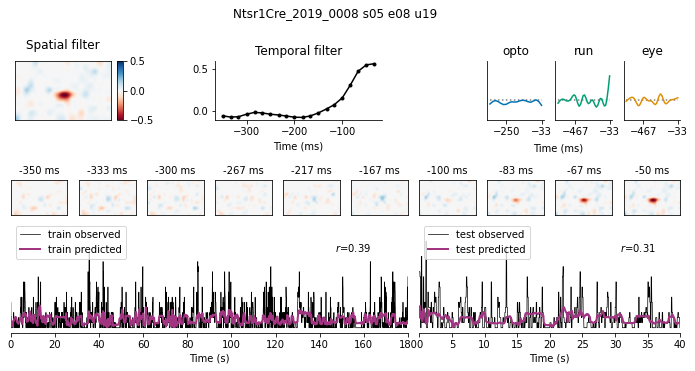

In [12]:
# Create evaluation dicts
# Training set
train_dict = dict(stimulus=data.stimulus['train'])
validation_dict = dict(stimulus=data.stimulus['validation'])
if paramdict['spl_pshf'] == 'True':
    train_dict['history'] = data.responses['train']
    validation_dict['history'] = data.responses['validation']
if paramdict['spl_opto'] == 'True':
    train_dict['opto'] = data.stimulus['opto_train']
    validation_dict['opto'] = data.stimulus['opto_validation']
if paramdict['spl_run'] == 'True':
    train_dict['run'] = data.responses['run_train']
    validation_dict['run'] = data.responses['run_validation']
if paramdict['spl_eye'] == 'True':
    train_dict['eye'] = data.responses['eye_train']
    validation_dict['eye'] = data.responses['eye_validation']
# Test set
test_dicts = []
for i in range(len(data.responses['test_repeats'])):
    test_dict = dict(stimulus=data.stimulus['test'])
    if paramdict['spl_pshf'] == 'True':
        test_dict['history'] = data.responses['test_repeats'][i]
    if paramdict['spl_opto'] == 'True':
        test_dict['opto'] = data.stimulus['opto_test_repeats'][i]
    if paramdict['spl_run'] == 'True':
        test_dict['run'] = data.responses['run_test_repeats'][i]
    if paramdict['spl_eye'] == 'True':
        test_dict['eye'] = data.responses['eye_test_repeats'][i]
    test_dicts.append(test_dict)

# Use outsourced plot_model function to access information eays
fig, axs = plot_model(parentkey, spl_lnp_model, data, paramdict, burn_in=0, savefig=False, add_info='some_info_you_want_in_the_file_name')

# Save and load model object

In [41]:
import pickle

# Saving model object
filename = hmov_utils.get_file_name(key, paramdict, add_info=None, filetype='pkl')
path = './data/'+filename
with open(path, 'wb') as lnp_file:
    print('Model object saved at '+path)
    pickle.dump(spl_lnp_model, lnp_file)

Model object saved as ./data/Ntsr1Cre_2019_0008_s05_e08_u19_paramset100_hmov_regularize1.00E+00_lr3.00E-01_iters1500_spatdf13_tempdf11_nlag20_pshfFalse_pshflen0_pshfdf0_optoTrue_optolen20_optodf11_runTrue_runlen40_rundf13_eyeTrue_eyelen40_eyedf13.pkl


In [43]:
import pickle

# Load saved model object
filename = hmov_utils.get_file_name(key, paramdict, add_info=None, filetype='pkl')
path = './data/'+filename
with open(path, 'rb') as lnp_file:
    print('Model object loaded from '+path)
    spl_lnp_model = pickle.load(lnp_file)

Model object loaded from ./data/Ntsr1Cre_2019_0008_s05_e08_u19_paramset100_hmov_regularize1.00E+00_lr3.00E-01_iters1500_spatdf13_tempdf11_nlag20_pshfFalse_pshflen0_pshfdf0_optoTrue_optolen20_optodf11_runTrue_runlen40_rundf13_eyeTrue_eyelen40_eyedf13.pkl


# How to use model & data objects

* access information:

In [16]:
spl_lnp_model.filter_names['train']

['stimulus', 'opto', 'run', 'eye']

* do compuations:

In [18]:
yhat_train = spl_lnp_model.predict(X=train_dict)

* plot data:

In [19]:
color_dict = plot.get_color_dict(color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])
color_dict_dark = plot.get_color_dict(palette_name='dark', color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])

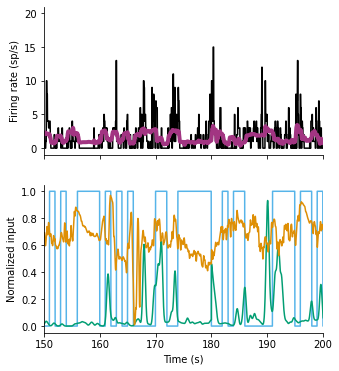

In [33]:
fig, axs = plt.subplots(2,1, figsize=(5,6), sharex=True)

axs[0].plot(data.data_t['train'], data.responses['train'], color='k', label='observed')
axs[0].plot(data.data_t['train'], yhat_train, color=color_dict_dark['pink'], linewidth=4)
axs[0].set_ylabel('Firing rate (sp/s)')

axs[1].plot(data.data_t['train'], data.stimulus['opto_train'], color=color_dict['lightblue'])
axs[1].plot(data.data_t['train'], data.responses['run_train'], color=color_dict['green'])
axs[1].plot(data.data_t['train'], data.responses['eye_train'], color=color_dict['orange'])
axs[1].set_xlim(150,200)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Normalized input')

sns.despine()